In [22]:
import torch
import torchvision.transforms as tr # 이미지 전처리 기능들을 제공하는 라이브러리
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset # 데이터를 모델에 사용할 수 있도록 정리해 주는 라이브러리
from torch import nn, optim # torch 내의 세부적인 기능을 불러온다. (신경망 기술, 손실함수, 최적화 방법 등)
import torch.nn.functional as F

import numpy as np # 넘파이 기본 라이브러리
import matplotlib.pyplot as plt #시각화
from sklearn.metrics import confusion_matrix # confusion matrix그리기용
import pandas as pd
import itertools

In [23]:
torch.manual_seed(1) #  random seed를 고정

In [24]:
# CPU/GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


### Data Load


In [25]:
# 데이터 관련
input_size = 28*28 # 784, 이미지 size가 28*28이므로
output_size = 10 # 클래스 : 0~9이므로

#파라미터 조정
batch_size = 64
lr = 0.01
epochs = 10

In [26]:
# transform 정의
transform = tr.Compose(
    [tr.ToTensor()])

trainset = datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True) 

testset = datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

### 모델 정의

In [27]:
#Logistic Regression
class Logistic(nn.Module): # 모델을 구성할 때 nn.Module을 상속받음
    def __init__(self):
        super(Logistic, self).__init__()  # nn.Module에서 상속받는 특성들을 초기화
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = x.reshape(x.shape[0],-1)
        x = self.linear(x)
        return x


In [28]:
# FNN 1 드랍아웃 이용! # 드랍아웃은 과적합(overfitting)을 방지하기 위해 노드의 일부를 배제
class FNN1(nn.Module):
    def __init__(self):
        super(FNN1, self).__init__()
        self.layer = nn.Sequential(nn.Linear(input_size, 256), # linear function, 입력층 784 > 은닉층 256으로 가는 연산
                      nn.ReLU(),# 활성화함수 ReLU
                      nn.Linear(256, 64), # linear function, 은닉층 256 > 은닉층 64으로 가는 연산
                      nn.ReLU()
                      )
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(64, output_size) # linear function, 은닉층 64 > 출력층 10으로 가는 연산
        

    def forward(self, x):
        x = x.view(x.shape[0],-1)
        x = self.layer(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [29]:
# FNN 2 배치 정규화 이용! # 학습하는 과정 자체를 전체적으로 안정화하여 학습 속도를 가속 시킬 수 있는 근본적인 방법, 그래디언트 소실,폭발 문제 방지

class FNN2(nn.Module):
    def __init__(self):
        super(FNN2, self).__init__()
        self.layer = nn.Sequential(nn.Linear(input_size, 256), # linear function, 입력층 784 > 은닉층 256으로 가는 연산
                      nn.BatchNorm1d(256),
                      nn.ReLU(),# 활성화함수 ReLU
                      nn.Linear(256, 64), # linear function, 은닉층 256 > 은닉층 64으로 가는 연산
                      nn.BatchNorm1d(64),
                      nn.ReLU()
                      )
        self.fc = nn.Linear(64, output_size) # linear function, 은닉층 64 > 출력층 10으로 가는 연산


    def forward(self, x):
        x = x.view(x.shape[0],-1)
        x = self.layer(x)
        x = self.fc(x)
        return x

In [30]:
# FNN 3 드랍아웃 & 배치 정규화 이용!
class FNN3(nn.Module):
    def __init__(self):
        super(FNN3, self).__init__()
        self.layer = nn.Sequential(nn.Linear(input_size, 256), # linear function, 입력층 784 > 은닉층 256으로 가는 연산
                      nn.BatchNorm1d(256),
                      nn.ReLU(),# 활성화함수 ReLU
                      nn.Linear(256, 64), # linear function, 은닉층 256 > 은닉층 64으로 가는 연산
                      nn.BatchNorm1d(64),
                      nn.ReLU()
                      )
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(64, output_size) # linear function, 은닉층 64 > 출력층 10으로 가는 연산
        

    def forward(self, x):
        x = x.view(x.shape[0],-1)
        x = self.layer(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

### 모델 선언

In [31]:
LR = Logistic().to(device)
FNN_1 = FNN1().to(device)
FNN_2 = FNN2().to(device)
FNN_3 = FNN3().to(device)

In [32]:
# 모델 구조 확인
print(LR)
print(FNN_1)
print(FNN_2)
print(FNN_3)

Logistic(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)
FNN1(
  (layer): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=10, bias=True)
)
FNN2(
  (layer): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (fc): Linear(in_features=64, out_features=10, bias=True)
)
FNN3(
  (layer): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3)

In [33]:
# https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)
    figure = plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### 모델 학습

In [34]:
criterion = nn.CrossEntropyLoss()# CrossEntropyLoss는 softmax 계산까지 포함되어 있으므로 모델의 마지막 output node에 별도의 활성화 함수를 사용하지 않아도 됨!
def train_model(model):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_,test_loss_,test_acc_,pred = [],[],[],[]
    n = len(trainloader) # 배치 개수
    for e in range(epochs): # epoch만큼 학습 진행
        running_loss = 0
        for i, data in enumerate(trainloader, 0):

            images, labels = data[0].to(device), data[1].to(device) # 배치 데이터 

            optimizer.zero_grad() # 초기화
            result = model(images) # 모델에서 훈련
            loss = criterion(result, labels)# 오차 계산
            
            loss.backward()# 역전파
            optimizer.step()# 스텝(파라미터 업데이트)

          
            running_loss += loss.item() # 오차값을 총 오차에 더함


        else:
            test_loss = 0
            correct = 0
            total = 0
            # Turn off gradients for validation, saves memory and computations
            # 자동 미분 off (어차피 test set에서 하는 작업이므로)
            with torch.no_grad():
      
                for data in testloader:
                    images, labels = data[0].to(device), data[1].to(device)
                    result = model(images)
                    test_loss = criterion(result, labels)
                    test_running_loss = test_loss.item() # loss.item()은 손실이 갖고 있는 scalar 값을 얻습니다.
                    _, predicted = torch.max(result.data, 1)
                    total += labels.size(0) # 개수 누적(총 개수)
                    correct += (predicted == labels).sum().item() # 누적(맞으면 1, 틀리면 0으로 합산)
                    if e == epochs-1:
                        pred.append(predicted)

            loss_.append(running_loss/n)
            test_loss_.append(test_running_loss/len(testloader))
            test_acc_.append(correct / total)
            print("Epoch: {}/{} ".format(e+1, epochs),
                  "Training Loss: {:.4f} ".format(running_loss/n),
                  "Test Loss: {:.4f} ".format(test_running_loss/n),
                  "Test Accuracy: {:.4f}".format(correct / total))


    return loss_,test_loss_,correct / total, pred


In [35]:
print("****LR*****")
loss_0,test_loss_0,acc_0,pred_0 = train_model(LR)
print("****FNN1*****")
loss_1,test_loss_1,acc_1,pred_1 = train_model(FNN_1)
print("****FNN2*****")
loss_2,test_loss_2,acc_2,pred_2 = train_model(FNN_2)
print("****FNN3*****")
loss_3,test_loss_3,acc_3,pred_3 = train_model(FNN_3)

****LR*****
Epoch: 1/10  Training Loss: 0.5580  Test Loss: 0.0003  Test Accuracy: 0.8097
Epoch: 2/10  Training Loss: 0.4933  Test Loss: 0.0004  Test Accuracy: 0.8254
Epoch: 3/10  Training Loss: 0.4891  Test Loss: 0.0006  Test Accuracy: 0.8250
Epoch: 4/10  Training Loss: 0.4865  Test Loss: 0.0004  Test Accuracy: 0.8296
Epoch: 5/10  Training Loss: 0.4719  Test Loss: 0.0004  Test Accuracy: 0.8288
Epoch: 6/10  Training Loss: 0.4737  Test Loss: 0.0007  Test Accuracy: 0.8122
Epoch: 7/10  Training Loss: 0.4700  Test Loss: 0.0007  Test Accuracy: 0.8217
Epoch: 8/10  Training Loss: 0.4646  Test Loss: 0.0005  Test Accuracy: 0.8333
Epoch: 9/10  Training Loss: 0.4708  Test Loss: 0.0006  Test Accuracy: 0.8240
Epoch: 10/10  Training Loss: 0.4779  Test Loss: 0.0007  Test Accuracy: 0.8078
****FNN1*****
Epoch: 1/10  Training Loss: 0.5781  Test Loss: 0.0004  Test Accuracy: 0.8294
Epoch: 2/10  Training Loss: 0.4643  Test Loss: 0.0004  Test Accuracy: 0.8254
Epoch: 3/10  Training Loss: 0.4336  Test Loss: 0.

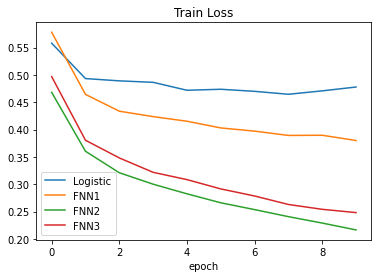

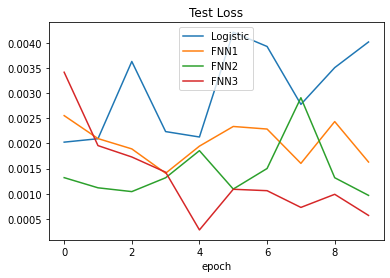

In [36]:
# Plotting
plt.plot(loss_0,label='Logistic')
plt.plot(loss_1,label='FNN1')
plt.plot(loss_2,label='FNN2')
plt.plot(loss_3,label='FNN3')
plt.xlabel("epoch")
plt.legend()
plt.title('Train Loss')
plt.show()

plt.plot(test_loss_0,label='Logistic')
plt.plot(test_loss_1,label='FNN1')
plt.plot(test_loss_2,label='FNN2')
plt.plot(test_loss_3,label='FNN3')
plt.xlabel("epoch")
plt.legend()
plt.title('Test Loss')
plt.show()



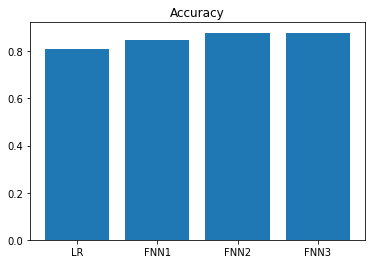

In [37]:
plt.bar(np.arange(4),[acc_0,acc_1,acc_2,acc_3])
plt.xticks(np.arange(4),['LR','FNN1','FNN2','FNN3'])
plt.title('Accuracy')
plt.show() # FNN2,FNN3이 성능이 가장 좋음

In [38]:
def cm(pred_):
    c_predict = []
    for _ in range(len(pred_)):
        for xx in pred_[_].tolist():
            c_predict.append(xx)
    cm=confusion_matrix(testset.targets.tolist(),c_predict)
    plot_confusion_matrix(cm,testset.classes ,normalize=True)

Normalized confusion matrix


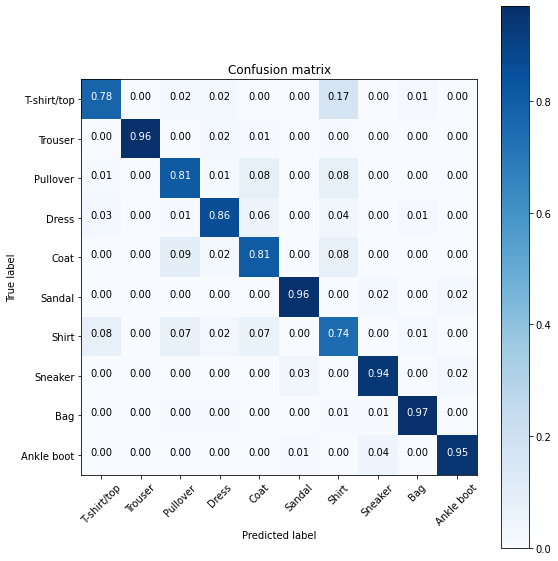

In [40]:
cm(pred_3)